In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

In [21]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from scipy.stats import bootstrap
from lifelines.utils import concordance_index


# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## Confidence Interval work

In [117]:
from util import import_and_shape_data, run_pycox_on_group

interval_and_weather_merged = import_and_shape_data()

# interval_and_weather_merged.to_csv('./data/interval_and_weather_merged.csv')

# remove events with length larger than 5000
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5000)]
interval_and_weather_merged.columns

(298, 21)
(46, 21)


Index(['Unnamed: 0', 'endtime', 'starttime', 'interval', 'departing_insect',
       'arriving_insect', 'sheet_title', 'timestamp_pd',
       'timestamp_pd_rounded', 'same_species', 'temp', 'dwpt', 'rhum', 'prcp',
       'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco', 'status'],
      dtype='object')

In [119]:
interval_and_weather_merged_dropped = interval_and_weather_merged.drop(columns=['Unnamed: 0', 'timestamp_pd_rounded', 'rhum', 'prcp',
       'snow', 'wdir', 'wpgt', 'tsun', 'pres', 'same_species'])
filter_df = interval_and_weather_merged_dropped[interval_and_weather_merged_dropped['departing_insect'] != "Insecta"]
filter_df

,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,temp,dwpt,wspd,coco,status
2,0 days 13:43:07,0 days 13:54:07,660.0,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,29.0,25.0,8.3,3.0,1
3,0 days 12:57:16,0 days 12:59:20,124.0,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,28.0,25.0,7.0,1.0,1
4,0 days 13:00:22,0 days 13:00:53,31.0,Apis mellifera,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:00:22,28.0,25.0,7.0,1.0,1
5,0 days 13:01:55,0 days 13:03:28,93.0,Augochlorini,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:01:55,28.0,25.0,7.0,1.0,1
6,0 days 11:50:31,0 days 12:25:31,2100.0,Melissodes bimaculatus (F),Melissodes bimaculatus (F),08-16-2022 i8 Cup plant,2022-08-16 11:50:31,21.0,18.9,6.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
41,0 days 12:17:54,0 days 13:09:55,3121.0,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,17.0,17.0,0.0,1.0,1
42,0 days 12:38:26,0 days 12:39:56,90.0,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,21.0,21.0,0.0,1.0,1
43,0 days 12:40:56,0 days 13:54:27,4411.0,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,21.0,21.0,0.0,1.0,1
44,0 days 13:10:55,0 days 13:20:55,600.0,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,21.0,21.0,0.0,1.0,1


In [33]:
def get_median_survival_time(predicted_surv_times, less_than_value):
    # Find the index of the first value that is less than 0.5
    less_than_half = predicted_surv_times.lt(less_than_value)
    

    first_less_than_half = less_than_half.idxmax()
    # print(first_less_than_half)

    return np.array(first_less_than_half)

In [ ]:
num_samples = len(interval_and_weather_merged)

bootstrap_sample = interval_and_weather_merged.sample(n=num_samples, replace=True, random_state=42)

print("Original Data:")
print(interval_and_weather_merged)

print("\nBootstrap Sample:")
print(bootstrap_sample)

In [95]:
def run_full_process(input_df):
    cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
    df_train = input_df[cols_input]

    fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_train, 1000)

    x_full = x_mapper.transform(input_df).astype('float32')
    surv = base_model.predict_surv_df(x_full)

    # Create a list to store median predicted survival times for each column
    median_predicted_survival_times = []

    # Iterate through each column in the 'surv' DataFrame
    for col_name in surv.columns:
        col_median = get_median_survival_time(surv[col_name], 0.5)
        median_predicted_survival_times.append(col_median.item())

    median_predicted_survival_times = [col_median for col_median in median_predicted_survival_times]

    c_index = concordance_index(input_df['interval'], median_predicted_survival_times, input_df['status'])
    print("Concordance Index outside of bootstrap:", c_index)
    return c_index

num_samples = len(interval_and_weather_merged)
statistics = []
for x in range(500):
    bootstrap_sample = interval_and_weather_merged.sample(n=num_samples, replace=True)
    # print(bootstrap_sample['departing_insect'])
    statistics.append(run_full_process(bootstrap_sample))

INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.7993037506855194
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9827331266396375
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9903573048189608
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9861707712867507
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.980126920507682
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9835815196639939
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9830728856018132
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concordance Index outside of bootstrap: 0.9861763793802629
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Concord

In [96]:
# Calculate the desired confidence level
confidence_level = 0.95

# Calculate the lower and upper percentiles for the confidence interval
alpha = (1 - confidence_level) / 2
lower_percentile = alpha * 100
upper_percentile = (1 - alpha) * 100

# Calculate the confidence interval using numpy.percentile
lower_bound = np.percentile(statistics, lower_percentile)
upper_bound = np.percentile(statistics, upper_percentile)

print("Confidence Interval:")
print(f"{confidence_level * 100:.2f}% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

Confidence Interval:
95.00% Confidence Interval: (0.89, 0.99)


In [ ]:

def pycox_concordance(data):
    # print(interval_and_weather_merged['status'].shape)
    print(data)
    # print(len(median_predicted_survival_times))
    # Calculate the concordance index
    c_index = concordance_index(data, median_predicted_survival_times, interval_and_weather_merged['status'])
    print("Concordance Index:", c_index)
    return c_index


data = (interval_and_weather_merged['interval'].to_list(), )
bootstrap_ci = bootstrap(data, pycox_concordance, confidence_level=0.95,
                         random_state=1, n_resamples=30, method='percentile')

In [64]:
df_test['interval'].shape

(58,)

## TODO:
~~- Change surv to be for the full dataset rather than just the test~~
~~- Get this to be run through the bootstrap function~~
- Do the same thing for the Cox PH Hazards one
- Figure out why you are getting lower concordance for your bootstrapped version

In [73]:
# get_median_survival_time(surv.iloc[:, :1], .5)

# surv.iloc[:, :1].to_csv('./tes_csv.csv')

# print(len(interval_and_weather_merged['interval']))


c_index = concordance_index(df_test['interval'], median_predicted_survival_times, df_test['status'])
print("Concordance Index:", c_index)


Concordance Index: 0.4517409896151497


In [ ]:
print(get_median_survival_time(surv.iloc[:, :1], .5))

surv.iloc[:, :1].to_csv('./tes_csv.csv')
median_predicted_survival_times

## Original runthrough

In [99]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1


In [100]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [101]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [102]:
# Don't understand what the y_train[0] indices are of? It seems like they only go up to
# the length of labtrans.cuts but I don't understand what the discretization grid that is 
# in labtrans.cuts is all about. 
labtrans.cuts[y_train[0]]



array([ 78.933334, 118.4     ,  78.933334, ..., 118.4     , 118.4     ,
        39.466667], dtype=float32)

In [103]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [104]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
0:	[0s / 0s],		train_loss: 3.0192,	val_loss: 2.8728
1:	[0s / 0s],		train_loss: 2.6930,	val_loss: 2.5938
2:	[0s / 0s],		train_loss: 2.4054,	val_loss: 2.2671
3:	[0s / 0s],		train_loss: 2.0663,	val_loss: 1.9400
4:	[0s / 0s],		train_loss: 1.7545,	val_loss: 1.7049
5:	[0s / 0s],		train_loss: 1.5303,	val_loss: 1.5943
6:	[0s / 0s],		train_loss: 1.4084,	val_loss: 1.5594
7:	[0s / 0s],		train_loss: 1.3816,	val_loss: 1.5439
8:	[0s / 0s],		train_loss: 1.3573,	val_loss: 1.5226
9:	[0s / 0s],		train_loss: 1.3289,	val_loss: 1.5065
10:	[0s / 0s],		train_loss: 1.3149,	val_loss: 1.5032
11:	[0s / 0s],		train_loss: 1.3079,	val_loss: 1.5049
12:	[0s / 0s],		train_loss: 1.2956,	val_loss: 1.5035
13:	[0s / 0s],		train_loss: 1.2792,	val_loss: 1.5031
14:	[0s / 0s],		train_loss: 1.2704,	val_loss: 1.5113
15:	[0s / 0s],		train_loss: 1.2767,	val_loss: 1.5177
16:	[0s / 0s],		train_loss: 1.2530,	val_loss: 1.5214
17:	[0s / 0s],		train_loss: 1.2399,	val_loss: 1.531

In [105]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

AttributeError: 'LogisticHazard' object has no attribute 'parameters'

In [9]:
print(type(val)) # , y_train, batch_size, epochs, callbacks, val)
print(val)

<class 'tuple'>
(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
         0.        ,  1.        ],
       [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
         0.        ,  1.        ],
       [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
         0.        ,  1.        ],
       [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32), (array([3, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 1, 5, 3, 2, 1, 5, 3, 4, 0, 2, 5,
       7, 5, 4, 3, 2, 4, 5, 6, 1, 1, 3, 7, 1, 1, 4, 2, 4, 6, 6, 1, 3, 6,
       2, 2, 4, 1, 2, 3, 4, 2, 2, 5, 4, 1, 1, 3, 6, 1, 5, 2, 3, 6, 2, 5,
       3, 2, 5, 4, 4, 4, 2, 1, 3, 2, 5, 2, 8, 4, 1, 2, 2, 2, 3, 2, 4, 1,
       3, 3, 1, 2, 3, 1, 5, 2, 6, 2, 3, 3, 5, 2, 6, 2, 4, 5, 

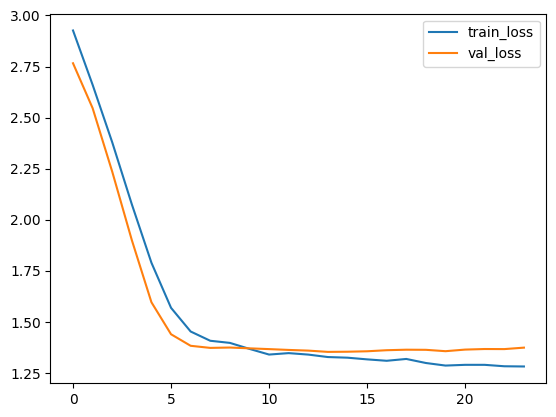

In [10]:
_ = log.plot()


In [11]:
log.to_pandas().val_loss.min()
model.score_in_batches(val)


{'loss': 1.3536216020584106}

,0,1,2,3,4
0.000000,0.993047,0.996519,0.979841,0.994583,0.997945
39.466667,0.866715,0.702471,0.873812,0.906963,0.824823
78.933334,0.573369,0.525651,0.709810,0.762157,0.598401
118.400002,0.372960,0.467122,0.542634,0.571630,0.393998
157.866669,0.250921,0.424454,0.458765,0.489412,0.185999
197.333344,0.192240,0.394627,0.407121,0.394265,0.073745
236.800003,0.108836,0.322134,0.248083,0.248157,0.010481
276.266663,0.046878,0.101619,0.172704,0.129991,0.001680
315.733337,0.025723,0.021652,0.056556,0.037607,0.000901
355.200012,0.009669,0.006572,0.003026,0.001963,0.000423


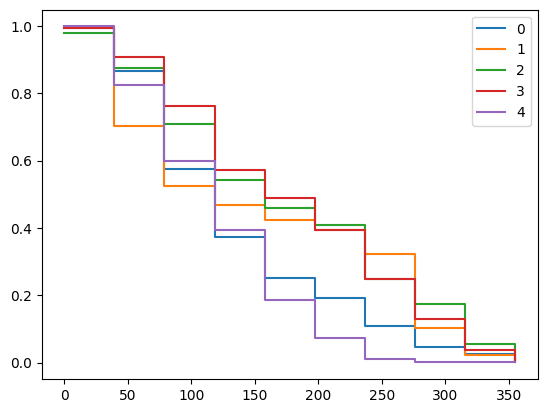

In [17]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
# plt.ylabel('S(t | x)')
# _ = plt.xlabel('Time')
surv_sample = surv.iloc[:, :5]
surv_sample


<Axes: >

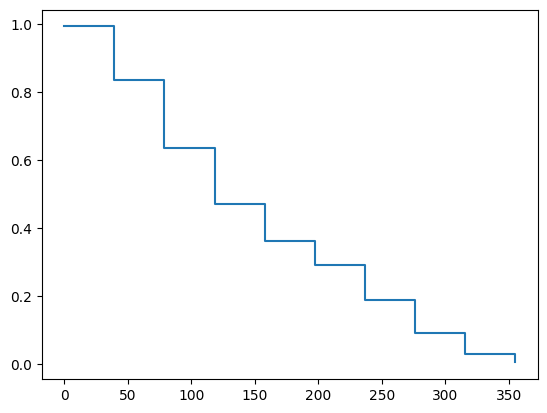

In [20]:
# calculate the mean
surv['mean'] = surv_sample.mean(axis=1)

surv['mean'].plot(drawstyle='steps-post')

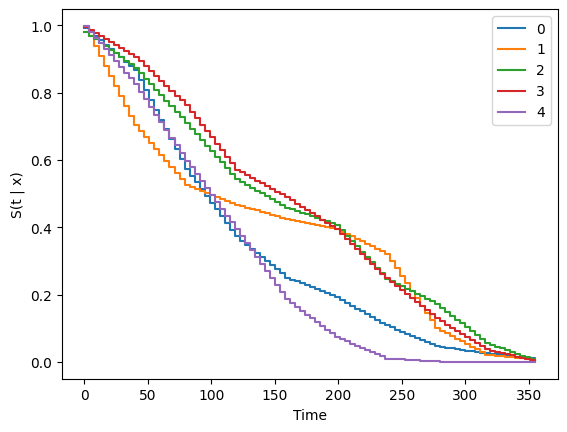

In [13]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


In [14]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# time_grid
# ev.brier_score(time_grid)


In [15]:
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# ev.brier_score(time_grid).plot()
# plt.ylabel('Brier score')
# _ = plt.xlabel('Time')